# "White" light images

The purpose of this notebook is to develop a technique to find normalization factors for the R and B bands (G being taken as unit) in order to use the raw pixels, once normalized, as pertaining to a "black-and-white" image of sorts. 

Each band is multiplied by an appropriate factor that should create, ideally, star images that are well behaved. That is, the different gains associated with each band must be accounted for so star images are represented by smooth peaks, and the background should look smooth (separate RGB pixels carry a similar signal to each other).

The final product should be a procedure that "conditions" each raw image to a state where star finding can be performed consistently over the entire image. Such procedure will be included in the star finding notebook as part of the entire process.

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
import photutils

import rawpy

Populating the interactive namespace from numpy and matplotlib


## Read and normalize test image

Start with last image in sequence. The last images have the highest exposure setting. This should make it easier for the star-finding algorithms to work. It also places every image in the sequence on the same side of the temporal sequence (shouldn't be a limiting factor though).

This procedure applies interpolation to the raw pixels, so it should not be used if we want the highest possible precision in centroiding. 

In [2]:
# read image file
path = '../astrophotography_data/MilkyWayPrettyBoy/'
list_p = glob.glob(os.path.join(path,'12800/light/*.ARW'))
fname = list_p[-1] # last

raw = rawpy.imread(fname)

In [3]:
# debayer
rgb = raw.postprocess(
    demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
    output_bps=16,
    gamma=(1,1), 
    use_camera_wb=False,
    use_auto_wb=False,
    no_auto_bright=True, 
    no_auto_scale=True,
    output_color=rawpy.ColorSpace.raw
)

red = rgb[::,::,0]
green = rgb[::,::,1]
blue = rgb[::,::,2]

Flat image was created by notebook Flat_analysis_1.ipynb

In [4]:
# read and normalize flat image (use this specific flat image)
flat_name = os.path.join(path, '12800/light/flat_raw_2.fits') 
hdul = fits.open(flat_name)
flat_red = hdul[1].data
flat_green = hdul[2].data
flat_blue = hdul[3].data

flat_red /= np.max(flat_red) 
flat_green /= np.max(flat_green)
flat_blue /= np.max(flat_blue) 

In [5]:
# normalize bands
norm_red = red / flat_red
norm_green = green / flat_green
norm_blue = blue / flat_blue

<IPython.core.display.Javascript object>


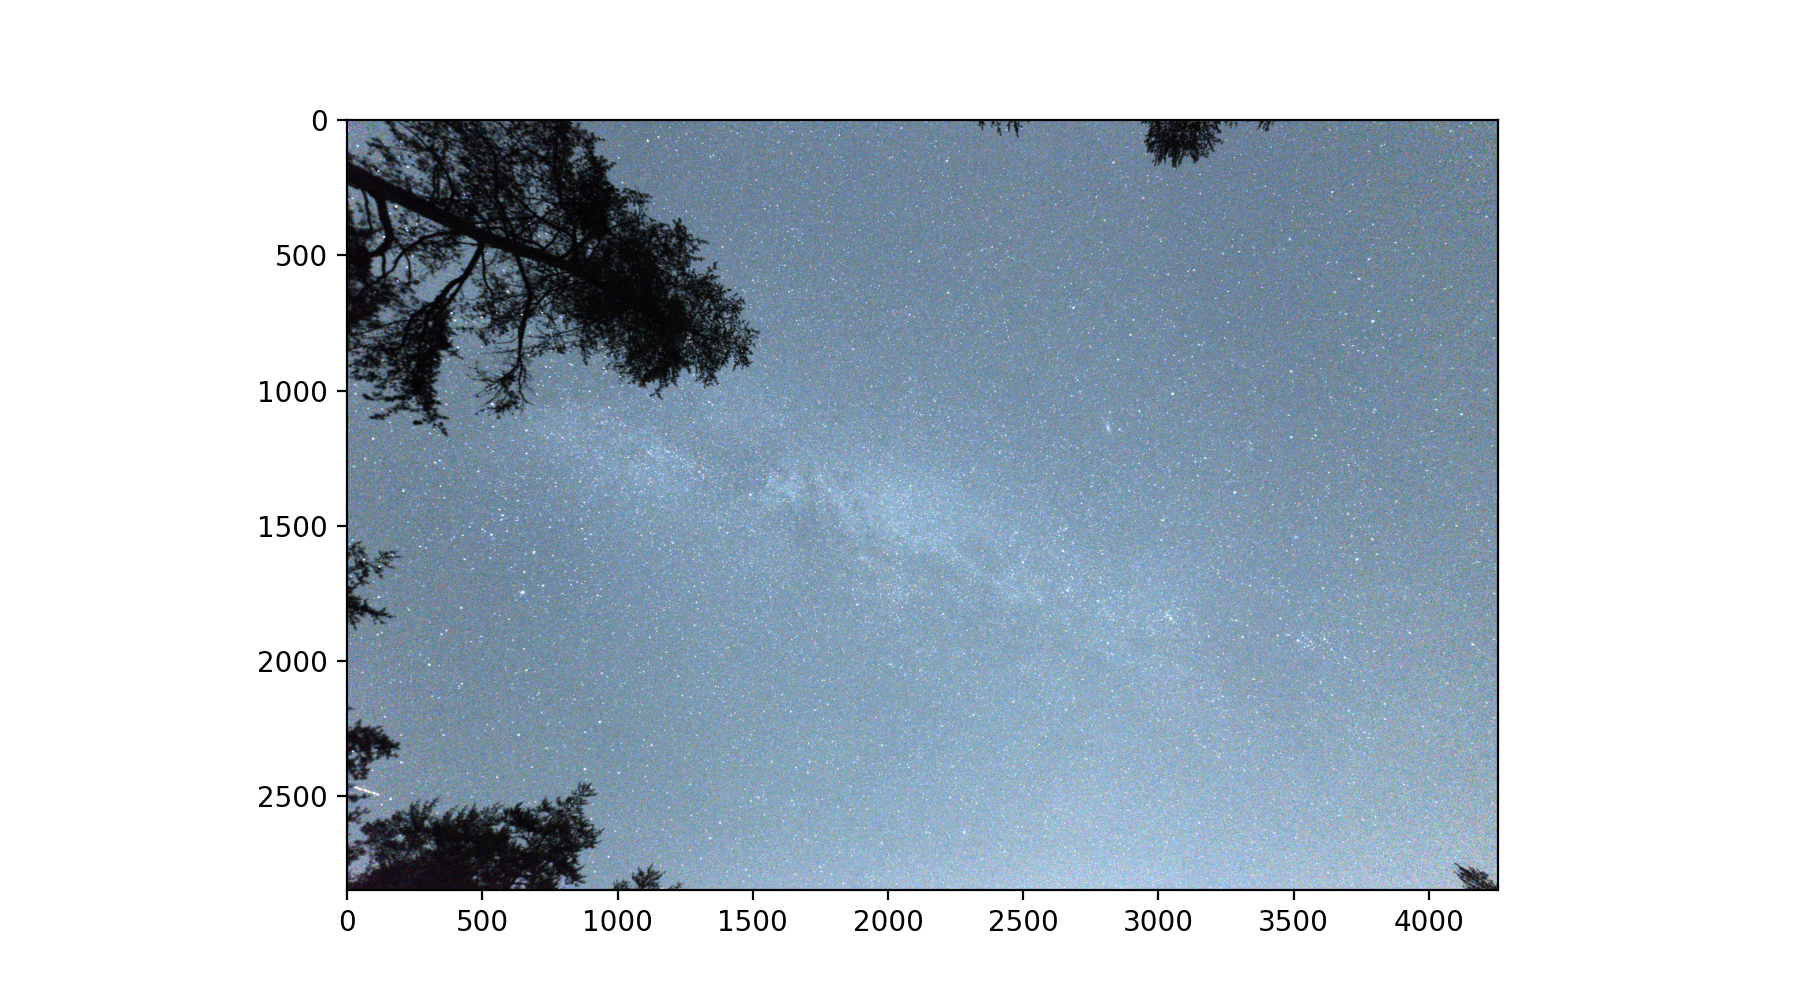

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
# Check result by reassembling bands into RGB image. Scale to fit matplotlib limits.
norm_rgb_scaled = np.zeros(shape=(red.shape[0],red.shape[1],3))

norm_factor = max(np.max(norm_red), np.max(norm_green), np.max(norm_blue))

norm_rgb_scaled[::,::,0] = norm_red / norm_factor * 60 * 1.2
norm_rgb_scaled[::,::,1] = norm_green / norm_factor * 30 * 1.4
norm_rgb_scaled[::,::,2] = norm_blue / norm_factor * 60 * 1.3

plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled)

<IPython.core.display.Javascript object>


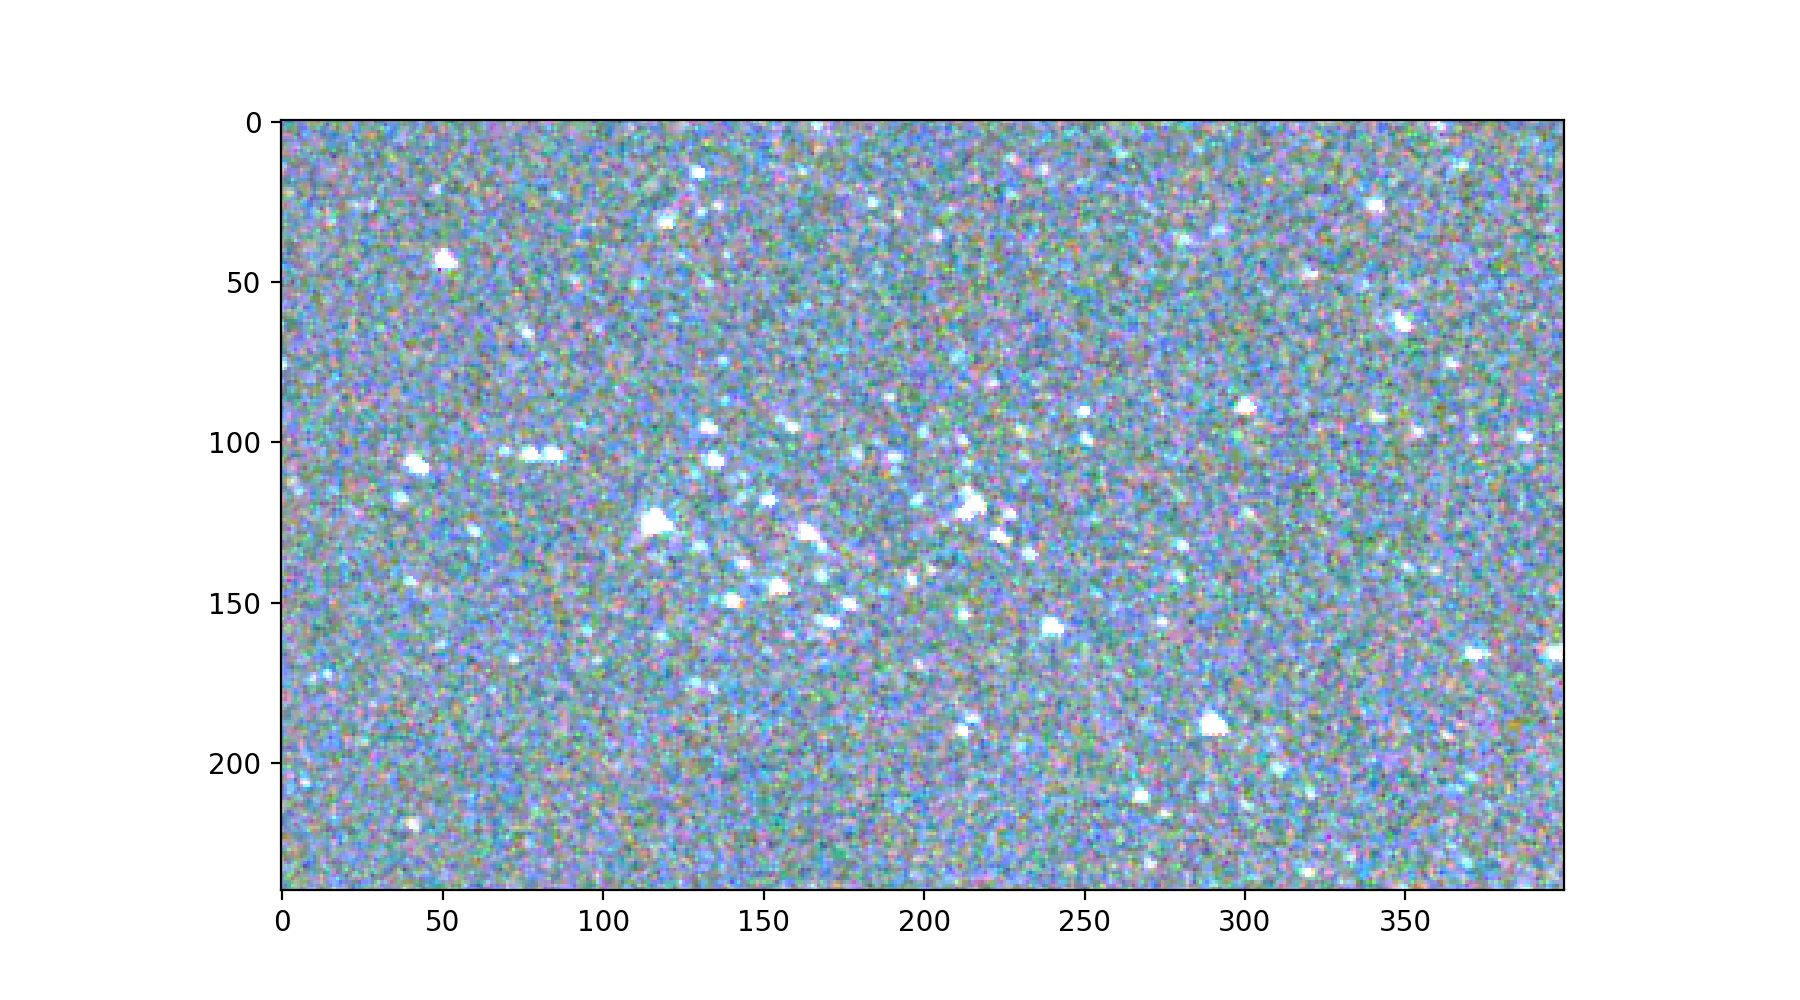

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled[1800:2040,3400:3800])

## Alternative procedure: combine RGB with weights

Instead of debayering, use the raw RGB array directly. 

In [8]:
# masks that isolate the RGB pixels 
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

In [9]:
# band normalization factors
# red_norm = 1.15     # minimization with flat (from paragraph below)
# green_norm = 1.0 
# blue_norm = 1.07

red_norm = 1.321875  # minimization with no flat (from paragraph below)
green_norm = 1.
blue_norm = 1.27695312

# factors defined based on Spectral_correction notebook
# red_norm = 2.28  # blackbody @T = 5778K 
# green_norm = 1.
# blue_norm = 1.55

# red_norm = 1.9  # blackbody @T = 4300K -> best fit with flat field raw image
# green_norm = 1.
# blue_norm = 1.9

# normalize by flat
imarray = raw.raw_image_visible.astype(float)

# masked flats are full of zeroed pixels. Use inverse instead.
flat_red_inv = np.ones_like(flat_red) / flat_red
flat_green_inv = np.ones_like(flat_green) / flat_green
flat_blue_inv = np.ones_like(flat_blue) / flat_blue

# these will cause the flat to be disregarded
flat_red_inv = np.ones_like(flat_red) 
flat_green_inv = np.ones_like(flat_green) 
flat_blue_inv = np.ones_like(flat_blue) 

raw_norm_1 = imarray * (flat_red_inv * red_mask * red_norm)
raw_norm_2 = raw_norm_1 + imarray * (flat_green_inv * green_mask * green_norm)
raw_norm = raw_norm_2 + imarray * (flat_blue_inv * blue_mask * blue_norm)

The normalization factors above where chosen based on work in the flat analysis notebook, plus the fact that they seem to generate the smoothest result.

The factors defined by RGB band integration with a solar spectrum are off. This is likely because the sky spectrum is far from a solar black-body. 

<IPython.core.display.Javascript object>


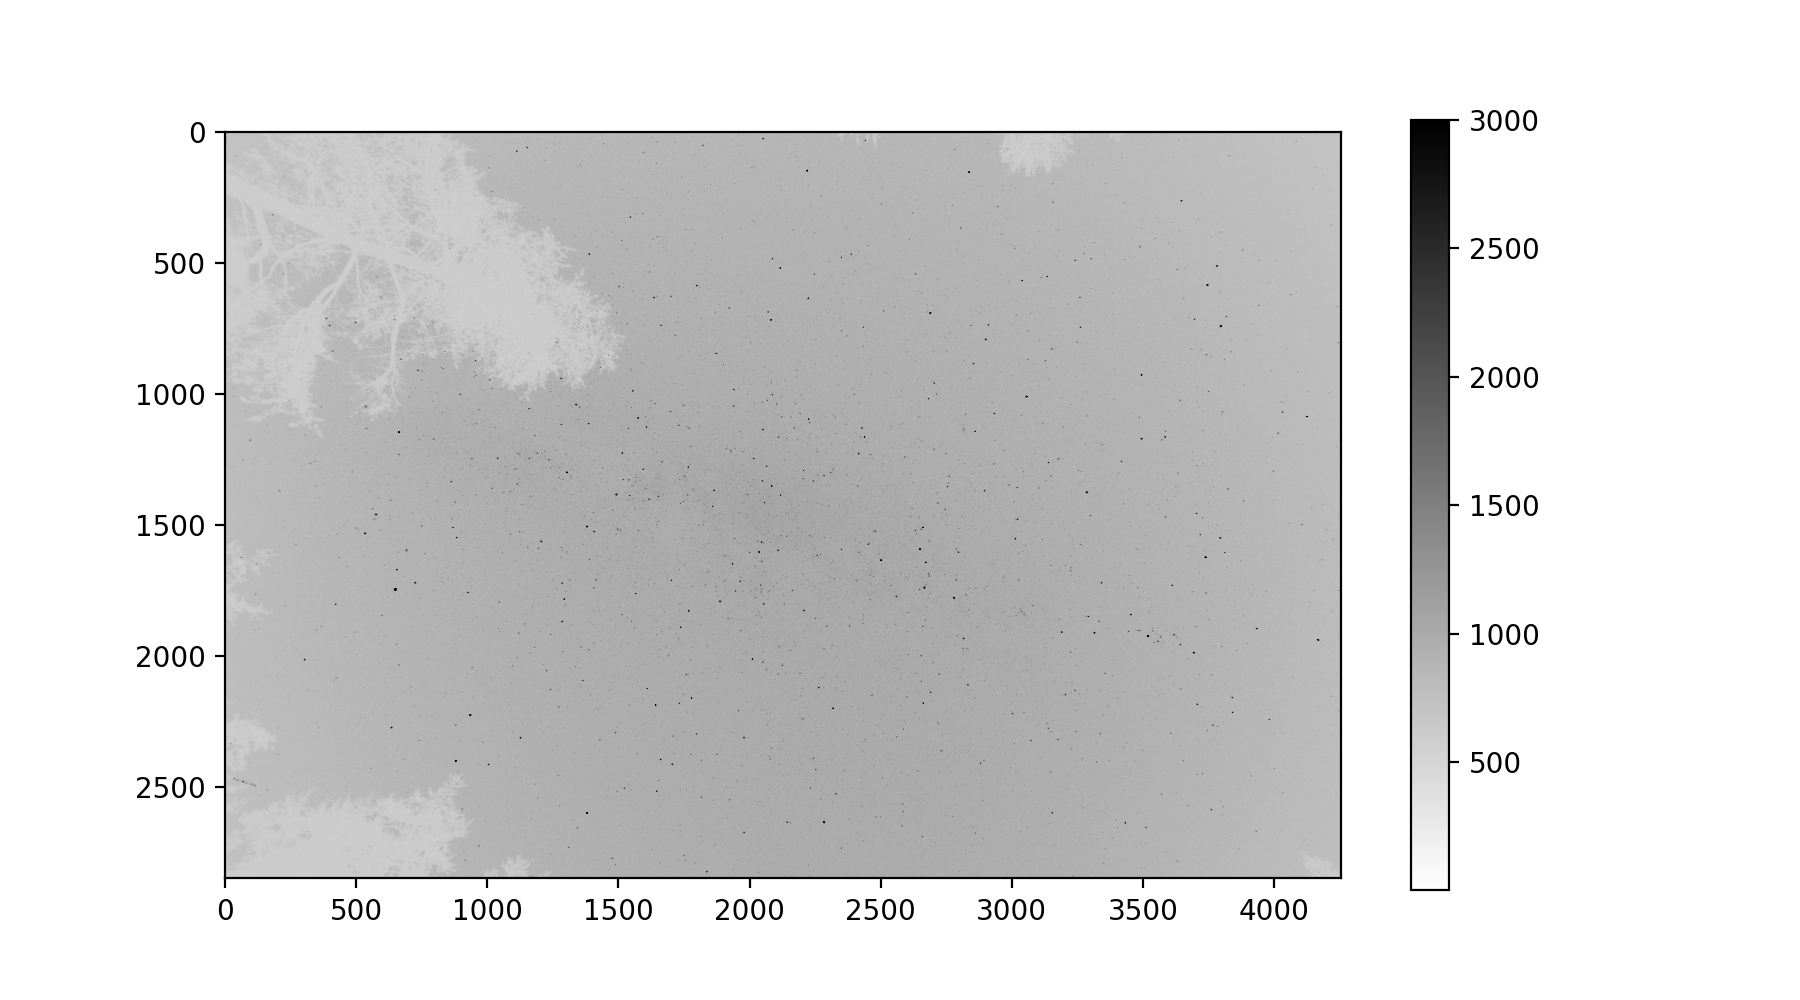

21656.278124999997
Relative standard deviation of a smooth patch:  0.08205201648885922


In [10]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmax=3000, cmap='binary')
# plt.imshow(raw_norm, vmax=28000, cmap='gist_stern')
plt.colorbar()

section = raw_norm[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

### Handle saturated pixels

If left unchecked, contiguous saturated pixels will result in a checkered pattern in the normalized image, because each band is multiplied by a different factor. 

We can fix this by forcing saturated pixels to be constant. This is not good for photometry, but for finding star centers should work fine.

<IPython.core.display.Javascript object>


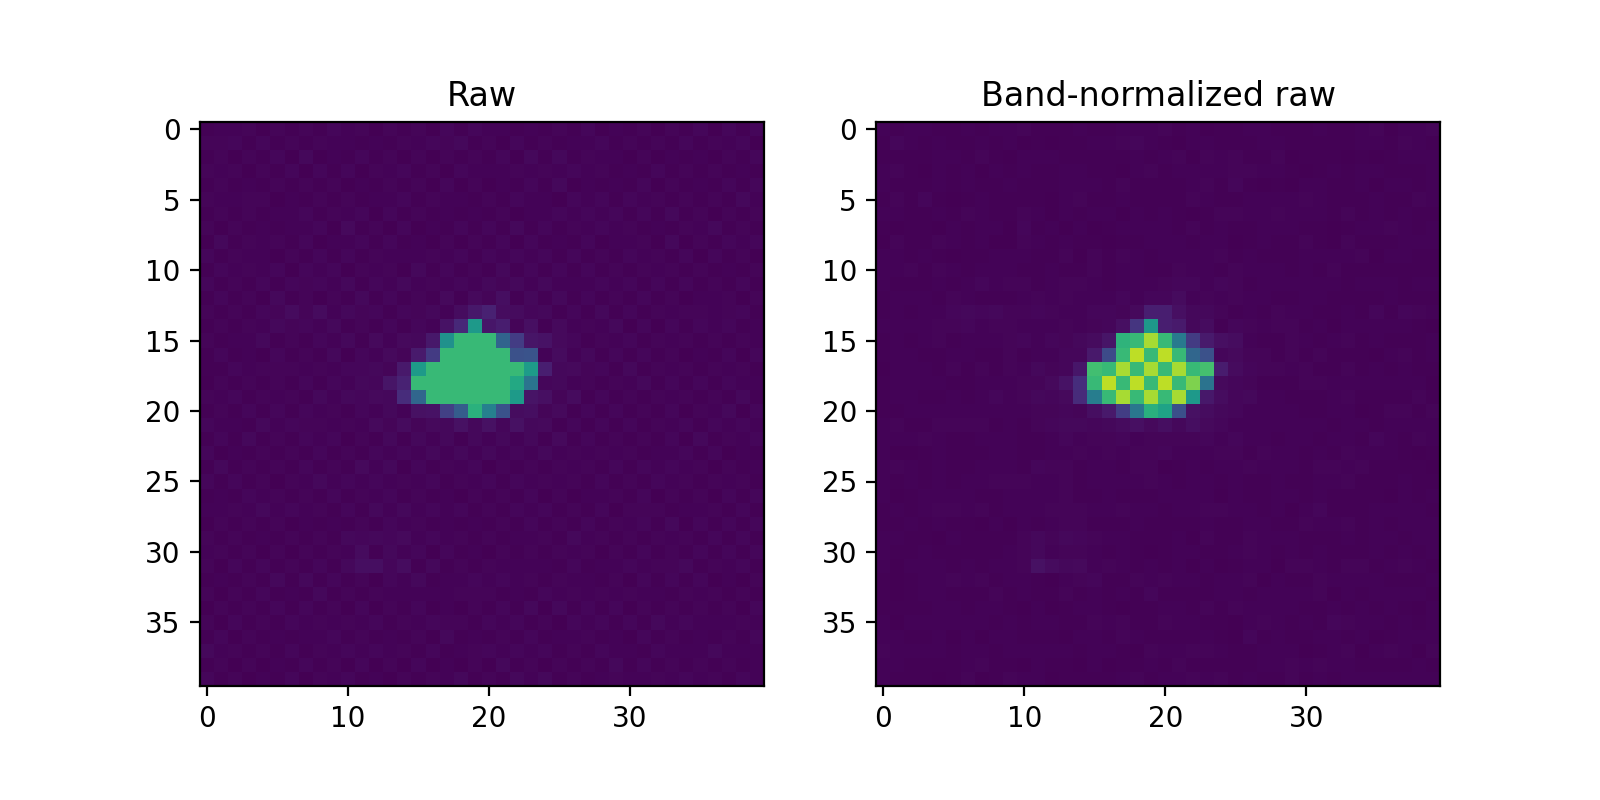

Text(0.5, 1.0, 'Band-normalized raw')

In [11]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(imarray[1730:1770,630:670], vmax=24000)
plt.title("Raw")
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm[1730:1770,630:670], vmax=24000)
plt.title("Band-normalized raw")

In [12]:
raw_norm = np.where(imarray > 16380, imarray, raw_norm)

<IPython.core.display.Javascript object>


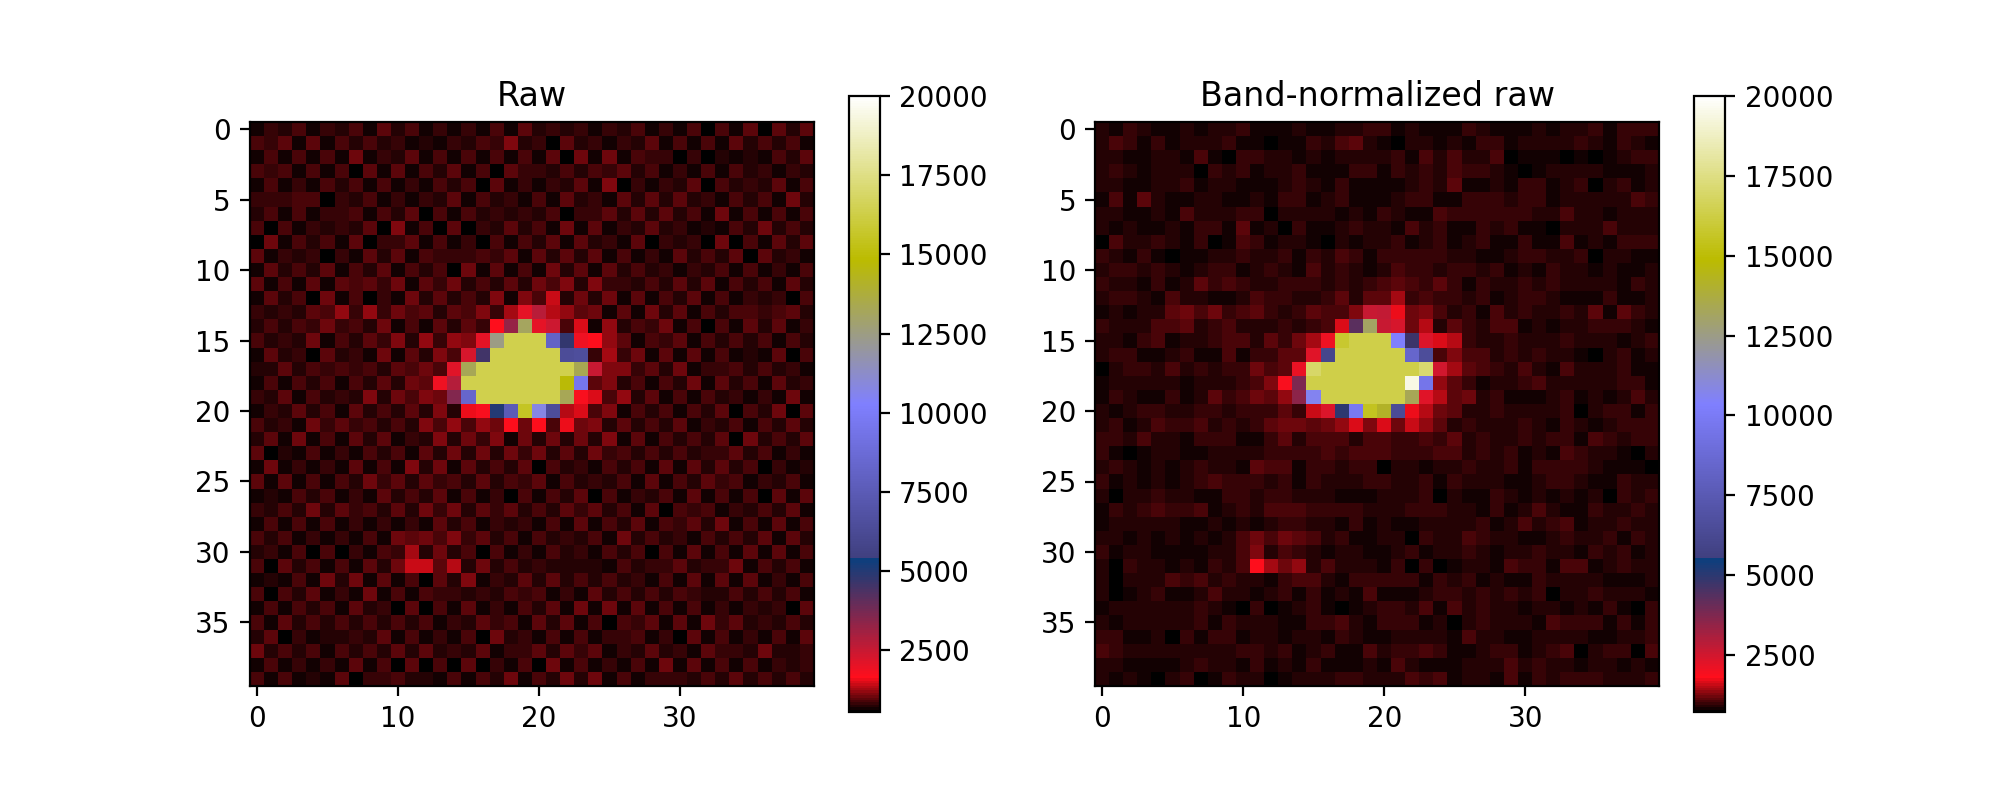

Text(0.5, 1.0, 'Band-normalized raw')

In [13]:
fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(imarray[1730:1770,630:670], vmax=20000, cmap='gist_stern')
plt.colorbar()
plt.title("Raw")
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm[1730:1770,630:670], vmax=20000, cmap='gist_stern')
plt.colorbar()
plt.title("Band-normalized raw")

### Double check with a flat field file

The point being: the flat field image was surely built with a blackbody spectrum. This should help in checking the self-consistency of the procedure. We don't know the spectrum of the sky, and most importantly, the stars.

Relative standard deviation of a smooth patch:  0.044001369120414635


<IPython.core.display.Javascript object>


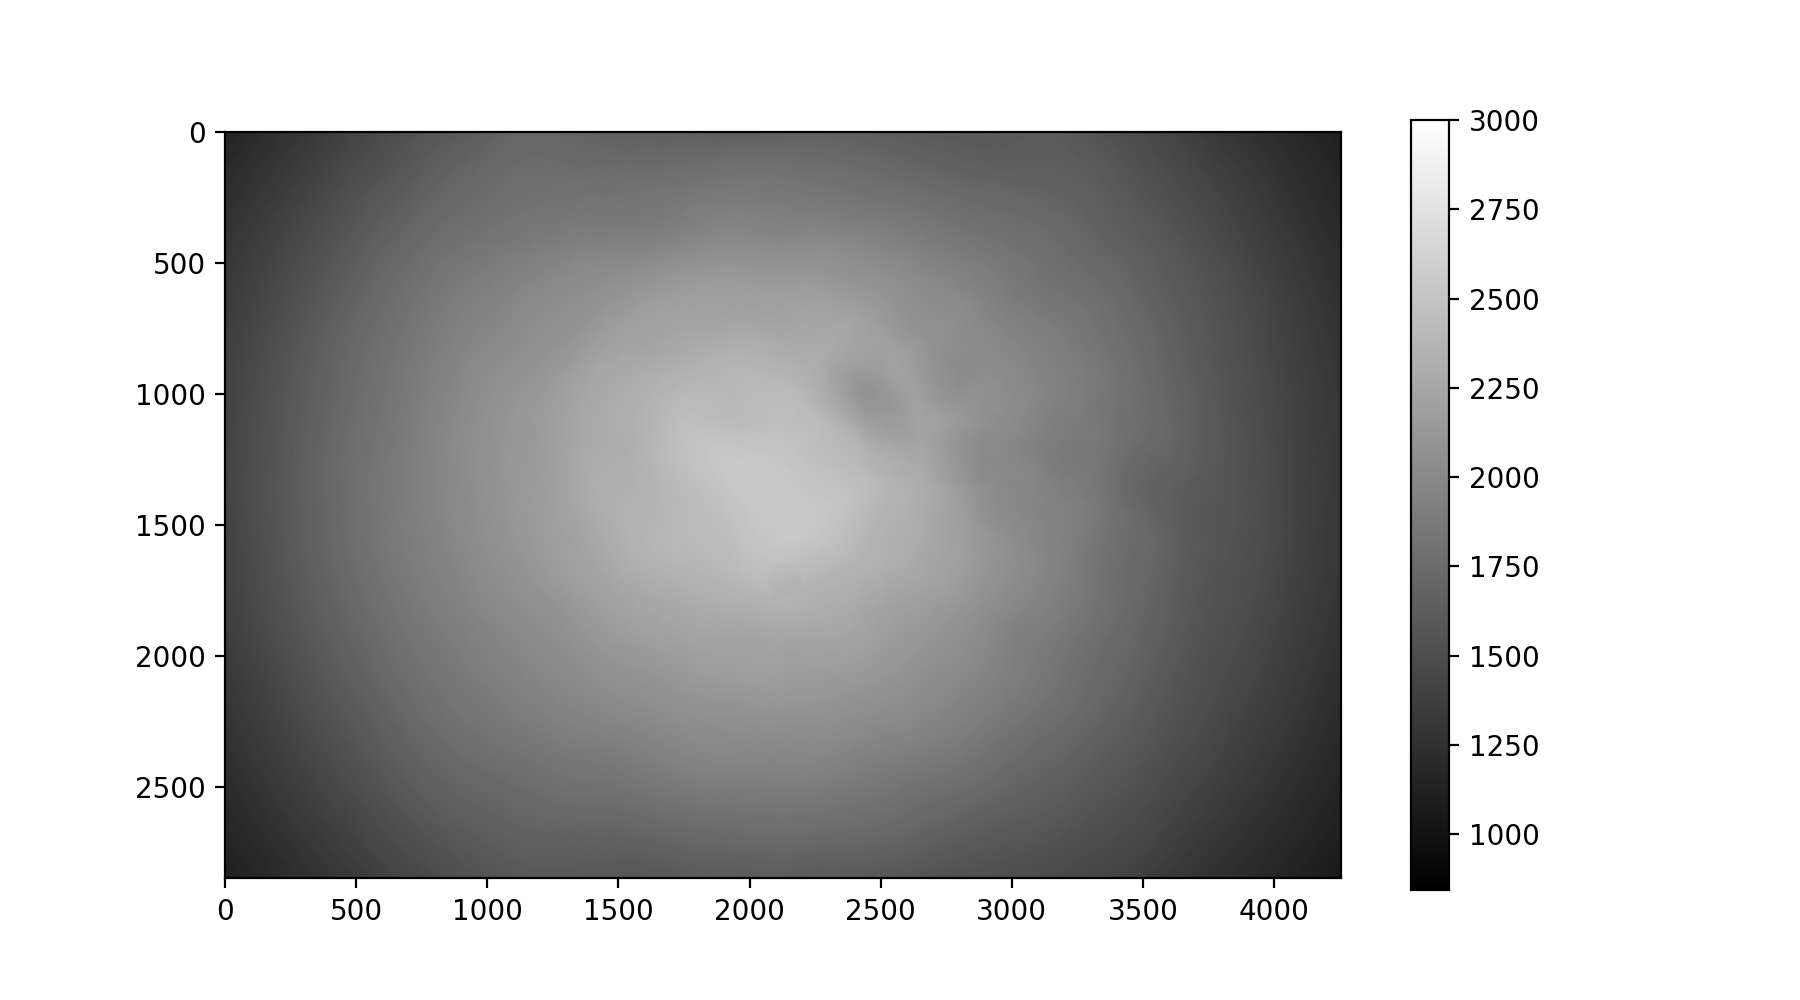

2713.2


In [14]:
f_fname = '../astrophotography_data/MilkyWayPrettyBoy/flats/raw_1/DSC06799.ARW'

f_raw = rawpy.imread(f_fname)
f_imarray = f_raw.raw_image_visible.astype(float)

red_norm = 1.9     # best fit with blackbody @ T=4300K
green_norm = 1.
blue_norm = 1.9

# normalize by flat
f_raw_norm_1 = f_imarray * (flat_red_inv * red_mask * red_norm)
f_raw_norm_2 = f_raw_norm_1 + f_imarray * (flat_green_inv * green_mask * green_norm)
f_raw_norm = f_raw_norm_2 + f_imarray * (flat_blue_inv * blue_mask * blue_norm)

section = f_raw_norm[1150:1250,1320:1420]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.average(section))

plt.figure(figsize=[9, 5])
print(np.max(f_raw_norm))
plt.imshow(f_raw_norm, vmax=3000, cmap='gray')
plt.colorbar()

A black body at 4300K gives the best (smoothest) fit in between the RGB pixels. This is consistent with the ligth that was used to build the flats: Sun light filtered by a lightly yellowish plastic bowl (see Flat Field Analysis notebook).

This is probably not good enough for handling the actual sky images, but at least verifies that the procedure of combining the RGB sub-arrays with weights derived from a spectrum, is sound. 

## Fit normalization coefficients to the background

Given the results above, a possible solution would be to find the normalization coefficients by minimizing the scatter in background values. 

We test the idea with the one test image from above. Later, we should verify if coefficients are valid for an entire set of images taken at the same run, with different exposure levels.

In [15]:
# optimization functions
def image_noise(array, x1, x2, y1, y2):
    slice_x = slice(x1,x2)
    slice_y = slice(y1,y2)

    median = np.median(array[slice_y,slice_x])
    std = np.std(array[slice_y,slice_x])
    
    return std / median

def normalize(coeffs):
    r_norm = coeffs[0]
    b_norm = coeffs[1]
   
    image_norm_1 = imarray * (flat_red_inv * red_mask * r_norm)
    image_norm_2 = image_norm_1 + imarray * (flat_green_inv * green_mask * 1.0)
    image_norm = image_norm_2 + imarray * (flat_blue_inv * blue_mask * b_norm)

    # define patch with no stars (or faint ones)
    x1 = 2670
    x2 = 2770
    y1 = 400
    y2 = 490
    
    return image_noise(image_norm, x1, x2, y1, y2)

In [17]:
res = minimize(normalize, (2., 1.), method='Nelder-Mead', tol=1e-2)
print(res.x, res.fun)

[1.33563595 1.24931204] 0.07977375142557273


At this point, we copy these values to the cell where they are used to normalize the input image and build image `raw_norm`.

### Verify over the set of all images

Compute R and B coefficients over the set of all images to verify stability.

In [18]:
# This takes a long time, but proves that a single pair of R,B coefficients is enough for the entire sequence.
# A different set of coefficients is required for each exposure value.

# list_images = glob.glob(os.path.join(path,'6400/light/*.ARW'))

# for filename in list_images:
#     raw = rawpy.imread(filename)
#     imarray = raw.raw_image_visible.astype(float)
   
#     res = minimize(normalize, (2., 1.), method='Nelder-Mead', tol=1e-2)
#     print(res.x, res.fun)